In [62]:
using RxInfer, Distributions, StableRNGs, Plots, Flux, CCMP
using Turing
using DynamicHMC, AdvancedVI
using BenchmarkTools
using Plots.PlotMeasures

In [2]:
function generate_data(f, g, n; seed = 123, x_i_min = -20.0, w_i_min = 20.0, noise = 1000.0, real_x_τ = 0.1, real_w_τ = 1.0)

    rng = StableRNG(seed)

    real_x = Vector{Float64}(undef, n)
    real_w = Vector{Float64}(undef, n)
    real_f = Vector{Float64}(undef, n)
    real_g = Vector{Float64}(undef, n)
    real_y = Vector{Float64}(undef, n)

    for i in 1:n
        real_x[i] = rand(rng, Normal(x_i_min, sqrt(1.0 / real_x_τ)))
        real_w[i] = rand(rng, Normal(w_i_min, sqrt(1.0 / real_w_τ)))
        real_f[i] = f(real_x[i], real_w[i])
        real_g[i] = g(real_f[i])
        real_y[i] = rand(rng, Normal(real_g[i], sqrt(noise)))

        x_i_min = real_x[i]
        w_i_min = real_w[i]
    end
    
    return real_x, real_w, real_f, real_g, real_y
end

generate_data (generic function with 1 method)

In [3]:
function smooth_min(x, y)    
    if x < y
        return x + 1e-4 * y
    else
        return y + 1e-4 * x
    end
end

function square(x)
    return (ref_point - x)^2
end

square (generic function with 1 method)

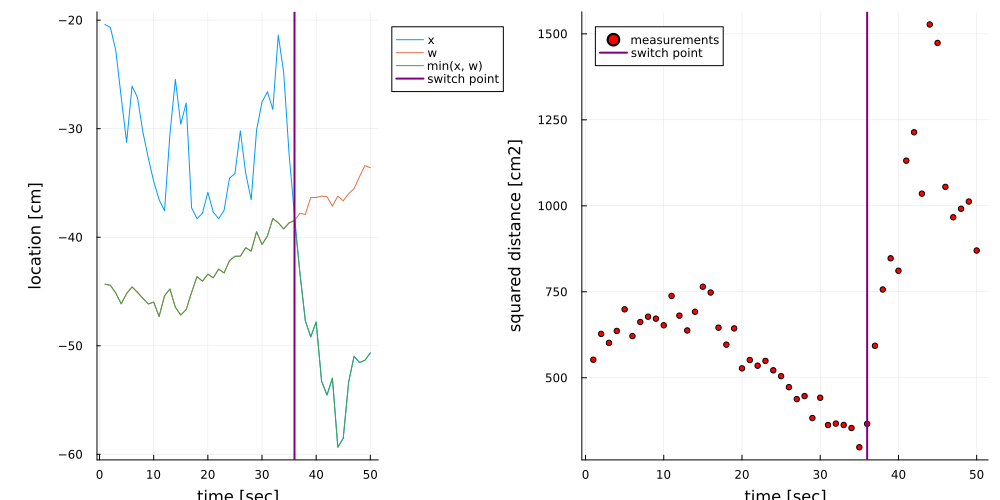

In [64]:
n = 50
ref_point = -20
switch_point = 36

x_i_min, w_i_min = -20, -45
real_x, real_w, real_f, real_g, real_y = generate_data(min, (x) -> (x - ref_point)^2 , n, x_i_min = x_i_min, w_i_min = w_i_min);

pl = plot(size=(1000, 500), legend = :outertopright, left_margin = 10mm)
pl = plot!(pl, real_x, label = "x")
pl = plot!(pl, real_w, label = "w")
pl = plot!(pl, real_f, label = "min(x, w)")
xlabel!("time [sec]"), ylabel!("location [cm]")
vline!([switch_point], linewidth=2, label="switch point", color = :purple)

pr = plot()
pr = scatter!(pr, real_y, ms = 3, color = :red, label = "measurements")
xlabel!("time [sec]"), ylabel!("squared distance [cm2]")
vline!([switch_point], linewidth=2, label="switch point", color = :purple)

plot(pl, pr)

In [65]:
savefig("min_observarions")

"/Users/mykola/repos/CIExpirements/demos/min_observarions.png"

In [106]:
# Turing model definition.
Turing.@model function NonlinearFiltering(y, r_point)
    # Get observation length.
    N = length(y)

    # State sequence.
    s = tzeros(Real, N)
    w = tzeros(Real, N)
    t = tzeros(Real, N)

    # set priors on precision parameters
    τ_s ~ Gamma(1.0, 1.0e-12)
    τ_w ~ Gamma(1.0, 1.0e-12)
    γ ~ Gamma(1.0, 1.0e-12)

    # Observe each point of the input.
    w[1] ~ Turing.Normal(0, τ_w)
    s[1] ~ Turing.Normal(0, τ_s)
    t[1] = min(s[1], w[1])
    y[1] ~ Turing.Normal((t[1] - r_point)^2, γ)

    for i in 2:N
        s[i] ~ Turing.Normal(s[i-1], τ_s)
        w[i] ~ Turing.Normal(s[i-1], τ_w)
        t[i] = min(s[i], w[i])
        y[i] ~ Turing.Normal((t[i] - r_point)^2, γ)
    end
end;
model = NonlinearFiltering(real_y, ref_point)

DynamicPPL.Model{typeof(NonlinearFiltering), (:y, :r_point), (), (), Tuple{Vector{Float64}, Int64}, Tuple{}, DynamicPPL.DefaultContext}(NonlinearFiltering, (y = [552.362901176716, 627.6207692179449, 601.5411905472171, 636.2079075110165, 698.9655753330849, 621.2301269521221, 662.115152436496, 677.6387395956724, 671.9340930410108, 652.6089749709128  …  1131.2596064005834, 1213.746643614895, 1035.340352762996, 1527.1299025695191, 1473.5181908206441, 1055.023377915483, 966.6434939204801, 991.407001013704, 1012.3795381510383, 870.0095108222073], r_point = -20), NamedTuple(), DynamicPPL.DefaultContext())

In [124]:
advi = ADVI(1000, 100)
q = vi(model, advi);

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 14727553611568112703
└ @ AdvancedVI /Users/mykola/.julia/packages/AdvancedVI/hVQ2g/src/AdvancedVI.jl:202


[ADVI] Optimizing...   2%  ETA: 0:07:57

[ADVI] Optimizing...   3%  ETA: 0:07:23

[ADVI] Optimizing...   4%  ETA: 0:07:06

[ADVI] Optimizing...   5%  ETA: 0:06:54

[ADVI] Optimizing...   6%  ETA: 0:06:44

[ADVI] Optimizing...   7%  ETA: 0:06:35

[ADVI] Optimizing...   8%  ETA: 0:06:28

[ADVI] Optimizing...   9%  ETA: 0:06:22

[ADVI] Optimizing...  10%  ETA: 0:06:16

[ADVI] Optimizing...  11%  ETA: 0:06:10

[ADVI] Optimizing...  12%  ETA: 0:06:05

[ADVI] Optimizing...  13%  ETA: 0:06:00

[ADVI] Optimizing...  14%  ETA: 0:05:55

[ADVI] Optimizing...  15%  ETA: 0:05:50

[ADVI] Optimizing...  16%  ETA: 0:05:46

[ADVI] Optimizing...  17%  ETA: 0:05:41

[ADVI] Optimizing...  18%  ETA: 0:05:36

[ADVI] Optimizing...  19%  ETA: 0:05:32

[ADVI] Optimizing...  20%  ETA: 0:05:19

[ADVI] Optimizing...  21%  ETA: 0:05:15

[ADVI] Optimizing...  22%  ETA: 0:05:11

[ADVI] Optimizing...  23%  ETA: 0:05:07

[ADVI] Optimizing...  24%  ETA: 0:05:03

[ADVI] Optimizing...  25%  ETA: 0:04:59

[ADVI] Optimizing...  26%  ETA: 0:04:55

[ADVI] Optimizing...  27%  ETA: 0:04:51

[ADVI] Optimizing...  28%  ETA: 0:04:48

[ADVI] Optimizing...  29%  ETA: 0:04:44

[ADVI] Optimizing...  30%  ETA: 0:04:39

[ADVI] Optimizing...  31%  ETA: 0:04:35

[ADVI] Optimizing...  32%  ETA: 0:04:31

[ADVI] Optimizing...  33%  ETA: 0:04:27

[ADVI] Optimizing...  34%  ETA: 0:04:22

[ADVI] Optimizing...  35%  ETA: 0:04:18

[ADVI] Optimizing...  36%  ETA: 0:04:14

[ADVI] Optimizing...  37%  ETA: 0:04:10

[ADVI] Optimizing...  38%  ETA: 0:04:07

[ADVI] Optimizing...  39%  ETA: 0:04:02

[ADVI] Optimizing...  40%  ETA: 0:03:58

[ADVI] Optimizing...  41%  ETA: 0:03:54

[ADVI] Optimizing...  42%  ETA: 0:03:50

[ADVI] Optimizing...  43%  ETA: 0:03:46

[ADVI] Optimizing...  44%  ETA: 0:03:42

[ADVI] Optimizing...  45%  ETA: 0:03:38

[ADVI] Optimizing...  46%  ETA: 0:03:34

[ADVI] Optimizing...  47%  ETA: 0:03:30

[ADVI] Optimizing...  48%  ETA: 0:03:26

[ADVI] Optimizing...  49%  ETA: 0:03:22

[ADVI] Optimizing...  50%  ETA: 0:03:18

[ADVI] Optimizing...  51%  ETA: 0:03:14

[ADVI] Optimizing...  52%  ETA: 0:03:10

[ADVI] Optimizing...  53%  ETA: 0:03:06

[ADVI] Optimizing...  54%  ETA: 0:03:02

[ADVI] Optimizing...  55%  ETA: 0:02:58

[ADVI] Optimizing...  56%  ETA: 0:02:54

[ADVI] Optimizing...  57%  ETA: 0:02:50

[ADVI] Optimizing...  58%  ETA: 0:02:46

[ADVI] Optimizing...  59%  ETA: 0:02:42

[ADVI] Optimizing...  60%  ETA: 0:02:38

[ADVI] Optimizing...  61%  ETA: 0:02:34

[ADVI] Optimizing...  62%  ETA: 0:02:30

[ADVI] Optimizing...  63%  ETA: 0:02:26

[ADVI] Optimizing...  64%  ETA: 0:02:22

[ADVI] Optimizing...  65%  ETA: 0:02:18

[ADVI] Optimizing...  66%  ETA: 0:02:14

[ADVI] Optimizing...  67%  ETA: 0:02:10

[ADVI] Optimizing...  68%  ETA: 0:02:06

[ADVI] Optimizing...  69%  ETA: 0:02:02

[ADVI] Optimizing...  70%  ETA: 0:01:58

[ADVI] Optimizing...  71%  ETA: 0:01:54

[ADVI] Optimizing...  72%  ETA: 0:01:51

[ADVI] Optimizing...  73%  ETA: 0:01:47

[ADVI] Optimizing...  74%  ETA: 0:01:43

[ADVI] Optimizing...  75%  ETA: 0:01:39

[ADVI] Optimizing...  76%  ETA: 0:01:35

[ADVI] Optimizing...  77%  ETA: 0:01:31

[ADVI] Optimizing...  78%  ETA: 0:01:27

[ADVI] Optimizing...  79%  ETA: 0:01:23

[ADVI] Optimizing...  80%  ETA: 0:01:19

[ADVI] Optimizing...  81%  ETA: 0:01:15

[ADVI] Optimizing...  82%  ETA: 0:01:11

[ADVI] Optimizing...  83%  ETA: 0:01:07

[ADVI] Optimizing...  84%  ETA: 0:01:03

[ADVI] Optimizing...  85%  ETA: 0:00:59

[ADVI] Optimizing...  86%  ETA: 0:00:55

[ADVI] Optimizing...  87%  ETA: 0:00:51

[ADVI] Optimizing...  88%  ETA: 0:00:47

[ADVI] Optimizing...  89%  ETA: 0:00:43

[ADVI] Optimizing...  90%  ETA: 0:00:39

[ADVI] Optimizing...  91%  ETA: 0:00:35

[ADVI] Optimizing...  92%  ETA: 0:00:31

[ADVI] Optimizing...  93%  ETA: 0:00:28

[ADVI] Optimizing...  94%  ETA: 0:00:24

[ADVI] Optimizing...  95%  ETA: 0:00:20

[ADVI] Optimizing...  96%  ETA: 0:00:16

[ADVI] Optimizing...  97%  ETA: 0:00:12

[ADVI] Optimizing...  98%  ETA: 0:00:08

[ADVI] Optimizing...  99%  ETA: 0:00:04

[ADVI] Optimizing... 100% Time: 0:06:33


In [128]:
q_samples = rand(q, 1000)
q_xmarginals = Vector{Any}(undef,50)
q_wmarginals = Vector{Any}(undef,50)
q_smarginals = Vector{Any}(undef,50)
for i in 1:50
    q_xmarginals[i] = q_samples[i+3, :]
    q_wmarginals[i] = q_samples[i+3+50, :]
    q_smarginals[i] = map((x) -> min(x[1], x[2]), zip(q_xmarginals[i], q_wmarginals[i]))
end

In [107]:
chn = sample(model, DynamicNUTS(), 1000);

Sampling   0%|                                          |  ETA: N/A


Sampling   0%|▎                                         |  ETA: 0:50:14
Sampling   1%|▍                                         |  ETA: 0:25:03
Sampling   2%|▋                                         |  ETA: 0:16:38


Sampling   2%|▉                                         |  ETA: 0:12:27
Sampling   2%|█                                         |  ETA: 0:09:56
Sampling   3%|█▎                                        |  ETA: 0:08:15
Sampling   4%|█▌                                        |  ETA: 0:07:02


Sampling   4%|█▋                                        |  ETA: 0:06:09
Sampling   4%|█▉                                        |  ETA: 0:05:26
Sampling   5%|██▏                                       |  ETA: 0:04:53
Sampling   6%|██▎                                       |  ETA: 0:04:25
Sampling   6%|██▌                                       |  ETA: 0:04:02


Sampling   6%|██▊                                       |  ETA: 0:03:43
Sampling   7%|███                                       |  ETA: 0:03:26
Sampling   8%|███▏                                      |  ETA: 0:03:11
Sampling   8%|███▍                                      |  ETA: 0:02:58
Sampling   8%|███▋                                      |  ETA: 0:02:47
Sampling   9%|███▊                                      |  ETA: 0:02:37
Sampling  10%|████                                      |  ETA: 0:02:28
Sampling  10%|████▎                                     |  ETA: 0:02:20
Sampling  10%|████▍                                     |  ETA: 0:02:12
Sampling  11%|████▋                                     |  ETA: 0:02:06
Sampling  12%|████▉                                     |  ETA: 0:02:00
Sampling  12%|█████                                     |  ETA: 0:01:54
Sampling  12%|█████▎                                    |  ETA: 0:01:49
Sampling  13%|█████▌                                    |  ETA: 

Sampling  14%|█████▋                                    |  ETA: 0:01:40
Sampling  14%|█████▉                                    |  ETA: 0:01:36
Sampling  14%|██████▏                                   |  ETA: 0:01:32
Sampling  15%|██████▎                                   |  ETA: 0:01:28
Sampling  16%|██████▌                                   |  ETA: 0:01:25
Sampling  16%|██████▊                                   |  ETA: 0:01:22
Sampling  16%|██████▉                                   |  ETA: 0:01:19
Sampling  17%|███████▏                                  |  ETA: 0:01:16
Sampling  18%|███████▍                                  |  ETA: 0:01:14
Sampling  18%|███████▌                                  |  ETA: 0:01:11
Sampling  18%|███████▊                                  |  ETA: 0:01:09
Sampling  19%|████████                                  |  ETA: 0:01:07
Sampling  20%|████████▎                                 |  ETA: 0:01:05
Sampling  20%|████████▍                                 |  ETA: 

Sampling  22%|█████████▌                                |  ETA: 0:00:54
Sampling  23%|█████████▋                                |  ETA: 0:00:53
Sampling  24%|█████████▉                                |  ETA: 0:00:51
Sampling  24%|██████████▏                               |  ETA: 0:00:50
Sampling  24%|██████████▎                               |  ETA: 0:00:48
Sampling  25%|██████████▌                               |  ETA: 0:00:47
Sampling  26%|██████████▊                               |  ETA: 0:00:46
Sampling  26%|██████████▉                               |  ETA: 0:00:45
Sampling  26%|███████████▏                              |  ETA: 0:00:44
Sampling  27%|███████████▍                              |  ETA: 0:00:43
Sampling  28%|███████████▌                              |  ETA: 0:00:42
Sampling  28%|███████████▊                              |  ETA: 0:00:41
Sampling  28%|████████████                              |  ETA: 0:00:40
Sampling  29%|████████████▏                             |  ETA: 

Sampling  32%|█████████████▌                            |  ETA: 0:00:34
Sampling  32%|█████████████▋                            |  ETA: 0:00:33
Sampling  33%|█████████████▉                            |  ETA: 0:00:32
Sampling  34%|██████████████▏                           |  ETA: 0:00:31
Sampling  34%|██████████████▎                           |  ETA: 0:00:31
Sampling  34%|██████████████▌                           |  ETA: 0:00:30
Sampling  35%|██████████████▊                           |  ETA: 0:00:29
Sampling  36%|██████████████▉                           |  ETA: 0:00:29
Sampling  36%|███████████████▏                          |  ETA: 0:00:28
Sampling  36%|███████████████▍                          |  ETA: 0:00:28
Sampling  37%|███████████████▌                          |  ETA: 0:00:27
Sampling  38%|███████████████▊                          |  ETA: 0:00:26
Sampling  38%|████████████████                          |  ETA: 0:00:26
Sampling  38%|████████████████▏                         |  ETA: 

Sampling  41%|█████████████████▎                        |  ETA: 0:00:23
Sampling  42%|█████████████████▍                        |  ETA: 0:00:22
Sampling  42%|█████████████████▋                        |  ETA: 0:00:22
Sampling  42%|█████████████████▉                        |  ETA: 0:00:22
Sampling  43%|██████████████████                        |  ETA: 0:00:21
Sampling  44%|██████████████████▎                       |  ETA: 0:00:21
Sampling  44%|██████████████████▌                       |  ETA: 0:00:20
Sampling  44%|██████████████████▊                       |  ETA: 0:00:20
Sampling  45%|██████████████████▉                       |  ETA: 0:00:20
Sampling  46%|███████████████████▏                      |  ETA: 0:00:19
Sampling  46%|███████████████████▍                      |  ETA: 0:00:19
Sampling  46%|███████████████████▌                      |  ETA: 0:00:18
Sampling  47%|███████████████████▊                      |  ETA: 0:00:18
Sampling  48%|████████████████████                      |  ETA: 

Sampling  50%|█████████████████████▎                    |  ETA: 0:00:16
Sampling  51%|█████████████████████▍                    |  ETA: 0:00:15
Sampling  52%|█████████████████████▋                    |  ETA: 0:00:15
Sampling  52%|█████████████████████▉                    |  ETA: 0:00:15
Sampling  52%|██████████████████████                    |  ETA: 0:00:15
Sampling  53%|██████████████████████▎                   |  ETA: 0:00:14
Sampling  54%|██████████████████████▌                   |  ETA: 0:00:14
Sampling  54%|██████████████████████▋                   |  ETA: 0:00:14
Sampling  55%|██████████████████████▉                   |  ETA: 0:00:13
Sampling  55%|███████████████████████▏                  |  ETA: 0:00:13
Sampling  56%|███████████████████████▎                  |  ETA: 0:00:13
Sampling  56%|███████████████████████▌                  |  ETA: 0:00:13
Sampling  56%|███████████████████████▊                  |  ETA: 0:00:12
Sampling  57%|████████████████████████                  |  ETA: 

Sampling  59%|████████████████████████▊                 |  ETA: 0:00:11
Sampling  60%|█████████████████████████                 |  ETA: 0:00:11
Sampling  60%|█████████████████████████▎                |  ETA: 0:00:11
Sampling  60%|█████████████████████████▍                |  ETA: 0:00:11
Sampling  61%|█████████████████████████▋                |  ETA: 0:00:10
Sampling  62%|█████████████████████████▉                |  ETA: 0:00:10
Sampling  62%|██████████████████████████                |  ETA: 0:00:10
Sampling  62%|██████████████████████████▎               |  ETA: 0:00:10
Sampling  63%|██████████████████████████▌               |  ETA: 0:00:10
Sampling  64%|██████████████████████████▋               |  ETA: 0:00:09
Sampling  64%|██████████████████████████▉               |  ETA: 0:00:09
Sampling  64%|███████████████████████████▏              |  ETA: 0:00:09
Sampling  65%|███████████████████████████▎              |  ETA: 0:00:09
Sampling  66%|███████████████████████████▌              |  ETA: 

Sampling  68%|████████████████████████████▍             |  ETA: 0:00:08
Sampling  68%|████████████████████████████▌             |  ETA: 0:00:08
Sampling  68%|████████████████████████████▊             |  ETA: 0:00:08
Sampling  69%|█████████████████████████████             |  ETA: 0:00:07
Sampling  70%|█████████████████████████████▎            |  ETA: 0:00:07
Sampling  70%|█████████████████████████████▍            |  ETA: 0:00:07
Sampling  70%|█████████████████████████████▋            |  ETA: 0:00:07
Sampling  71%|█████████████████████████████▉            |  ETA: 0:00:07
Sampling  72%|██████████████████████████████            |  ETA: 0:00:07
Sampling  72%|██████████████████████████████▎           |  ETA: 0:00:06
Sampling  72%|██████████████████████████████▌           |  ETA: 0:00:06
Sampling  73%|██████████████████████████████▋           |  ETA: 0:00:06
Sampling  74%|██████████████████████████████▉           |  ETA: 0:00:06
Sampling  74%|███████████████████████████████▏          |  ETA: 

Sampling  78%|████████████████████████████████▊         |  ETA: 0:00:05
Sampling  78%|█████████████████████████████████         |  ETA: 0:00:04
Sampling  79%|█████████████████████████████████▏        |  ETA: 0:00:04
Sampling  80%|█████████████████████████████████▍        |  ETA: 0:00:04
Sampling  80%|█████████████████████████████████▋        |  ETA: 0:00:04
Sampling  80%|█████████████████████████████████▊        |  ETA: 0:00:04
Sampling  81%|██████████████████████████████████        |  ETA: 0:00:04
Sampling  82%|██████████████████████████████████▎       |  ETA: 0:00:04
Sampling  82%|██████████████████████████████████▌       |  ETA: 0:00:04
Sampling  82%|██████████████████████████████████▋       |  ETA: 0:00:03
Sampling  83%|██████████████████████████████████▉       |  ETA: 0:00:03
Sampling  84%|███████████████████████████████████▏      |  ETA: 0:00:03
Sampling  84%|███████████████████████████████████▎      |  ETA: 0:00:03
Sampling  84%|███████████████████████████████████▌      |  ETA: 

Sampling  88%|████████████████████████████████████▊     |  ETA: 0:00:02
Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:02
Sampling  88%|█████████████████████████████████████▏    |  ETA: 0:00:02
Sampling  89%|█████████████████████████████████████▍    |  ETA: 0:00:02
Sampling  90%|█████████████████████████████████████▋    |  ETA: 0:00:02
Sampling  90%|█████████████████████████████████████▊    |  ETA: 0:00:02
Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:02
Sampling  91%|██████████████████████████████████████▎   |  ETA: 0:00:02
Sampling  92%|██████████████████████████████████████▍   |  ETA: 0:00:02
Sampling  92%|██████████████████████████████████████▋   |  ETA: 0:00:01
Sampling  92%|██████████████████████████████████████▉   |  ETA: 0:00:01
Sampling  93%|███████████████████████████████████████   |  ETA: 0:00:01
Sampling  94%|███████████████████████████████████████▎  |  ETA: 0:00:01
Sampling  94%|███████████████████████████████████████▌  |  ETA: 

Sampling  98%|█████████████████████████████████████████ |  ETA: 0:00:00
Sampling  98%|█████████████████████████████████████████▏|  ETA: 0:00:00
Sampling  98%|█████████████████████████████████████████▍|  ETA: 0:00:00
Sampling  99%|█████████████████████████████████████████▋|  ETA: 0:00:00
Sampling 100%|█████████████████████████████████████████▊|  ETA: 0:00:00
Sampling 100%|██████████████████████████████████████████| Time: 0:00:16
Sampling 100%|██████████████████████████████████████████| Time: 0:00:16


In [110]:
chn

Chains MCMC chain (1000×104×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 16.79 seconds
Compute duration  = 16.79 seconds
parameters        = τ_s, τ_w, γ, w[1], w[2], w[3], w[4], w[5], w[6], w[7], w[8], w[9], w[10], w[11], w[12], w[13], w[14], w[15], w[16], w[17], w[18], w[19], w[20], w[21], w[22], w[23], w[24], w[25], w[26], w[27], w[28], w[29], w[30], w[31], w[32], w[33], w[34], w[35], w[36], w[37], w[38], w[39], w[40], w[41], w[42], w[43], w[44], w[45], w[46], w[47], w[48], w[49], w[50], s[1], s[2], s[3], s[4], s[5], s[6], s[7], s[8], s[9], s[10], s[11], s[12], s[13], s[14], s[15], s[16], s[17], s[18], s[19], s[20], s[21], s[22], s[23], s[24], s[25], s[26], s[27], s[28], s[29], s[30], s[31], s[32], s[33], s[34], s[35], s[36], s[37], s[38], s[39], s[40], s[41], s[42], s[43], s[44], s[45], s[46], s[47], s[48], s[49], s[50]
internals         = lp

Summary Statistics
  parameters      mean       std      mcse   ess

In [119]:
xmarginals = Vector{Any}(undef,50)
wmarginals = Vector{Any}(undef,50)
smarginals = Vector{Any}(undef,50)
for i in 1:50
    xmarginals[i] = chn["s[$(i)]"]
    wmarginals[i] = chn["w[$(i)]"]
    smarginals[i] = map((x) -> min(x[1], x[2]), zip(xmarginals[i], wmarginals[i]))
end

In [ ]:
mean.(xmarginals[end])

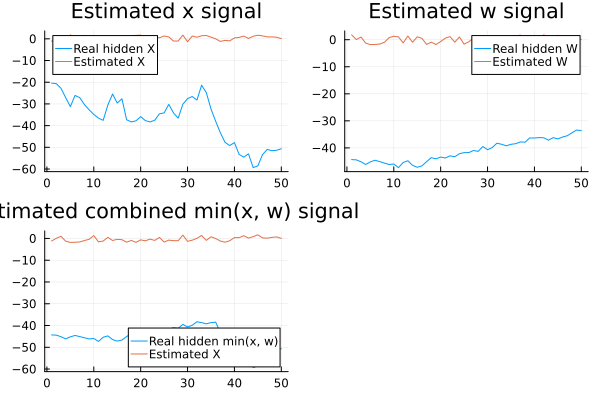

In [123]:
pxx = plot(legend = :topleft, title = "Estimated x signal")
pxw = plot(legend = :topright, title = "Estimated w signal")
pxs = plot(legend = :bottomright, title = "Estimated combined min(x, w) signal")
pxt = plot(legend = :bottomright, title = "Estimated combined and squared signal")

pxx = plot!(pxx, real_x, label = "Real hidden X")
pxx = plot!(pxx, mean.(xmarginals), ribbon = var.(xmarginals), label = "Estimated X")

pxw = plot!(pxw, real_w, label = "Real hidden W")
pxw = plot!(pxw, mean.(wmarginals), ribbon = [min(var, 100) for var in var.(wmarginals[end])], label = "Estimated W")

pxs = plot!(pxs, real_f, label = "Real hidden min(x, w)")
pxs = plot!(pxs, mean.(smarginals), ribbon = var.(smarginals), label = "Estimated X")

# pxt = plot!(pxt, real_g, label = "Squared singal")
# pxt = plot!(pxt, mean.(tmarginals[end]), ribbon = var.(tmarginals[end]), label = "Estimated X")

plot(pxx, pxw, pxs)

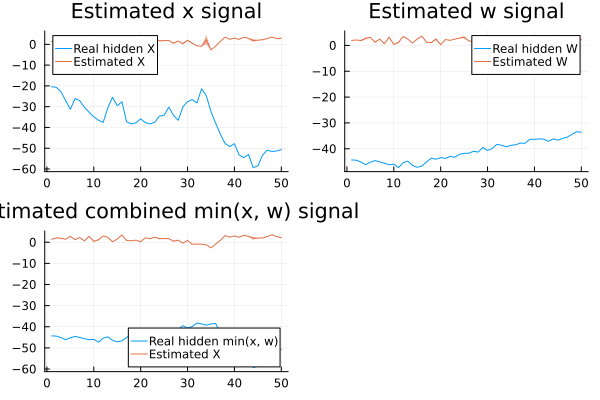

In [129]:
pxx = plot(legend = :topleft, title = "Estimated x signal")
pxw = plot(legend = :topright, title = "Estimated w signal")
pxs = plot(legend = :bottomright, title = "Estimated combined min(x, w) signal")
pxt = plot(legend = :bottomright, title = "Estimated combined and squared signal")

pxx = plot!(pxx, real_x, label = "Real hidden X")
pxx = plot!(pxx, mean.(q_xmarginals), ribbon = var.(q_xmarginals), label = "Estimated X")

pxw = plot!(pxw, real_w, label = "Real hidden W")
pxw = plot!(pxw, mean.(q_wmarginals), ribbon = [min(var, 100) for var in var.(q_wmarginals)], label = "Estimated W")

pxs = plot!(pxs, real_f, label = "Real hidden min(x, w)")
pxs = plot!(pxs, mean.(q_smarginals), ribbon = var.(q_smarginals), label = "Estimated X")

# pxt = plot!(pxt, real_g, label = "Squared singal")
# pxt = plot!(pxt, mean.(tmarginals[end]), ribbon = var.(tmarginals[end]), label = "Estimated X")

plot(pxx, pxw, pxs)

In [130]:
AdvancedVI.elbo(advi, q, model, 100000)

-1.0499936109530243e12